<center>
    
![](https://drive.google.com/uc?export=view&id=1R6EAVE0Ysym-UNtZR-Ze_HcqQLDmH0bd)
<p>

<h1 style="font-size: 4rem; color: black;">&nbsp;</h1>

<center>
    <h1 style="font-size: 2rem; color: black;">College: Engineering and Information Technology</h1>
    <h1 style="font-size: 2rem; color: black;">Department: Information Technology</h1>
    <h1 style="font-size: 2rem; color: black;">Program: Data Analytics</h1>
    <h1 style="font-size: 5rem; color: black;">Text & Web Mining Project</h1>
    <h1 style="font-size: 3rem; color: black;">(DAT-402)</h1>
</center>

<h1 style="font-size: 3.5rem; color: black;">&nbsp;</h1>

<center>
    <h1 style="font-size: 20rem; color: black;">Project 1 - Arabic Text Discretization (ATD)</h1>
    <h1 style="font-size: 2rem; color: black;">Prepared by:</h1>
    <h1 style="font-size: 2rem; color:#b74eba;">Haniyah Alzaben-202110616</h1>
    <h1 style="font-size: 2rem; color:#b74eba;">Layan Ahmad-202110844</h1>
    <h1 style="font-size: 2rem; color:#b74eba;">Leena Alsalihi-202110613</h1>
    <h1 style="font-size: 2rem; color:#b74eba;">Supervised by:</h1>
    <h1 style="font-size: 2rem; color:#b74eba;">Dr. Mahmoud AlShboul</h1>
</center>

<h1 style="font-size: 2.5rem; color: black;">&nbsp;</h1>

<center>
<h1 style="font-size: 2.5rem; color: black;">Academic Year 2024-2025 - Fall</h1>
</center>

# **Importing Necessary Libraries:**

---



First of all, we will import all the necessary libraries that we will use throughout the project. This generally includes libraries for data manipulation, data visualization, and others based on the specific needs of the project.

---


In [ ]:
# Standard libraries
import random
import time
import pickle as pkl
import re
import unicodedata
from collections import Counter

# Data manipulation and processing
import numpy as np
import pandas as pd

# Natural Language Processing (NLP)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# TensorFlow and Keras
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, TimeDistributed
from keras.initializers import glorot_normal
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from plotly.subplots import make_subplots

# torch and transformers
import torch
from transformers import AutoTokenizer
from transformers import AdamW
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
from tqdm import tqdm
import torch.nn as nn
from torch.nn.modules.activation import MultiheadAttention

# **Collecting Data**

---



**Reading train.txt and val.txt into Python lists**

In [ ]:
with open("/content/train.txt", "r", encoding="utf-8") as file:
    train = file.readlines()

with open("/content/val.txt", "r", encoding="utf-8") as file:
    val = file.readlines()

**We set the dataset and constants paths and then load the Arabic letters, diacritics, and character mappings from pickle files. Depending on whether WITH_EXTRA_TRAIN is True or False, we load either the big or small character mappings.**

In [ ]:
WITH_EXTRA_TRAIN = False
DATASET_PATH = '../../../dataset'
CONSTANTS_PATH = '../../../helpers/constants'

with open('/content/ARABIC_LETTERS_LIST.pickle', 'rb') as file:
    ARABIC_LETTERS_LIST = pkl.load(file)
with open('/content/DIACRITICS_LIST.pickle', 'rb') as file:
    DIACRITICS_LIST = pkl.load(file)
if not WITH_EXTRA_TRAIN:
    with open('/content/RNN_SMALL_CHARACTERS_MAPPING.pickle', 'rb') as file:
        CHARACTERS_MAPPING = pkl.load(file)
else:
    with open('/content/RNN_BIG_CHARACTERS_MAPPING.pickle', 'rb') as file:
        CHARACTERS_MAPPING = pkl.load(file)
with open('/content/RNN_CLASSES_MAPPING.pickle', 'rb') as file:
    CLASSES_MAPPING = pkl.load(file)
with open('/content/RNN_REV_CLASSES_MAPPING.pickle', 'rb') as file:
    REV_CLASSES_MAPPING = pkl.load(file)

# **Data Cleaning**

---



**We define a function to remove diacritics from the input text by translating and deleting all characters in the `DIACRITICS_LIST`.**

In [ ]:
def remove_diacritics(data_raw):
    return data_raw.translate(str.maketrans('', '', ''.join(DIACRITICS_LIST)))

**This `to_one_hot` function converts a list of indices into one-hot encoded vectors of a specified size.**

In [ ]:
def to_one_hot(data, size):
    one_hot = list()
    for elem in data:
        cur = [0] * size
        cur[elem] = 1
        one_hot.append(cur)
    return one_hot

**The `split_data` function processes raw text by splitting it into smaller chunks based on punctuation, removing diacritics, and ensuring that each chunk is no longer than 500 characters.**

In [ ]:
def split_data(data_raw):
    data_new = list()

    for line in data_raw:
        line = line.replace('.', '.\n')
        line = line.replace(',', ',\n')
        line = line.replace('،', '،\n')
        line = line.replace(':', ':\n')
        line = line.replace(';', ';\n')
        line = line.replace('؛', '؛\n')
        line = line.replace('(', '\n(')
        line = line.replace(')', ')\n')
        line = line.replace('[', '\n[')
        line = line.replace(']', ']\n')
        line = line.replace('{', '\n{')
        line = line.replace('}', '}\n')
        line = line.replace('«', '\n«')
        line = line.replace('»', '»\n')

        for sub_line in line.split('\n'):
            if len(remove_diacritics(sub_line).strip()) == 0:
                continue

            if len(remove_diacritics(sub_line).strip()) > 0 and len(remove_diacritics(sub_line).strip()) <= 500:
                data_new.append(sub_line.strip())
            else:
                sub_line = sub_line.split()
                tmp_line = ''
                for word in sub_line:
                    if len(remove_diacritics(tmp_line).strip()) + len(remove_diacritics(word).strip()) + 1 > 500:
                        if len(remove_diacritics(tmp_line).strip()) > 0:
                            data_new.append(tmp_line.strip())
                        tmp_line = word
                    else:
                        if tmp_line == '':
                            tmp_line = word
                        else:
                            tmp_line += ' '
                            tmp_line += word
                if len(remove_diacritics(tmp_line).strip()) > 0:
                    data_new.append(tmp_line.strip())

    return data_new

**The `clean_text` function removes unwanted characters, including punctuation, numbers, and English/Arabic letters, from the input text using regular expressions.**

In [ ]:
def  clean_text(text):
    text = re.sub(r"[-()\"#/@;:_<>{}`﴾﴿ے+=~&|.!?,a-zA-Z0-9٠-٩]", "", text)
    return text

**The `map_data` function converts raw text into input-output pairs for training by mapping characters to integers using predefined mappings, excluding diacritics, and encoding the output with corresponding diacritics. It also pads the sequences to ensure uniform length and returns the processed data as numpy arrays.**

In [ ]:
def map_data(data_raw):
    X = []
    Y = []

    for line in data_raw:
        x = [CHARACTERS_MAPPING['<SOS>']]
        y = [CLASSES_MAPPING['<SOS>']]

        for idx, char in enumerate(line):
            if char in DIACRITICS_LIST:
                continue

            x.append(CHARACTERS_MAPPING.get(char, CHARACTERS_MAPPING['<PAD>']))  # Use <PAD> if char is not found

            if char not in ARABIC_LETTERS_LIST:
                y.append(CLASSES_MAPPING[''])
            else:
                char_diac = ''
                if idx + 1 < len(line) and line[idx + 1] in DIACRITICS_LIST:
                    char_diac = line[idx + 1]
                    if idx + 2 < len(line) and line[idx + 2] in DIACRITICS_LIST and char_diac + line[idx + 2] in CLASSES_MAPPING:
                        char_diac += line[idx + 2]
                    elif idx + 2 < len(line) and line[idx + 2] in DIACRITICS_LIST and line[idx + 2] + char_diac in CLASSES_MAPPING:
                        char_diac = line[idx + 2] + char_diac
                y.append(CLASSES_MAPPING[char_diac])

        assert(len(x) == len(y))

        x.append(CHARACTERS_MAPPING['<EOS>'])
        y.append(CLASSES_MAPPING['<EOS>'])

        y = to_one_hot(y, len(CLASSES_MAPPING))

        X.append(x)
        Y.append(y)

    # Pad sequences to ensure uniform length
    X = pad_sequences(X, padding='post', value=CHARACTERS_MAPPING['<PAD>'])
    Y = pad_sequences(Y, padding='post', value=to_one_hot([CLASSES_MAPPING['<PAD>']], len(CLASSES_MAPPING))[0])

    return np.asarray(X), np.asarray(Y)


**The `DataGenerator` class is a custom data generator for Keras, designed to feed batches of data into the model during training. It converts lines of text into input-output pairs using the `map_data` function, ensures that all sequences in a batch have the same length by padding them, and returns the padded batches for both input (X) and output (Y) sequences.**

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, lines, batch_size, **kwargs):
        super().__init__(**kwargs)  # Call superclass constructor
        self.lines = lines
        self.batch_size = batch_size

    def __len__(self): # Computes the number of batches needed to cover the entire dataset
        return int(np.ceil(len(self.lines) / float(self.batch_size)))

    def __getitem__(self, idx): # Retrieves a batch of data given the batch index (idx).
        lines = self.lines[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch, Y_batch = map_data(lines) #Calling the map_data function to convert lines into the required format for model input

        X_max_seq_len = np.max([len(x) for x in X_batch]) #the maximum sequence length for both input (X) and output (Y) sequences in the current batch.
        Y_max_seq_len = np.max([len(y) for y in Y_batch])

        assert(X_max_seq_len == Y_max_seq_len)

        # makes the input sequences (X_batch) and output sequences (Y_batch) to have the same maximum sequence length using padding characters (<PAD>).
        #   |
        #   V
        X = list()
        for x in X_batch:
            x = list(x)
            x.extend([CHARACTERS_MAPPING['<PAD>']] * (X_max_seq_len - len(x)))
            X.append(np.asarray(x))

        Y_tmp = list()
        for y in Y_batch:
            y_new = list(y)
            y_new.extend(to_categorical([CLASSES_MAPPING['<PAD>']] * (Y_max_seq_len - len(y)), len(CLASSES_MAPPING)))
            Y_tmp.append(np.asarray(y_new))
        Y_batch = Y_tmp

        Y_batch = np.array(Y_batch)

        return (np.array(X), Y_batch)

**The `fit_model` function trains the model using data generators for training and validation batches. It sets up an early stopping callback to prevent overfitting by monitoring validation loss, and restores the best model weights if no improvement is seen for a set number of epochs. The function then fits the model for the specified number of epochs and returns the training history.**

In [ ]:
def fit_model(model, epochs, batch_size, train_subset,val_split):
    ''' Fits model '''


    # create training and validation generators using DataGenerator
    training_generator = DataGenerator(train_subset, batch_size)
    val_generator = DataGenerator(val_split, batch_size)

        # Set up EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',      # Monitor validation loss ('val_accuracy' can also be used)
        patience=3,              # Number of epochs with no improvement before stopping
        restore_best_weights=True  # Restore weights from the epoch with the best validation loss
    )

    # fit model
    history = model.fit(x=training_generator,
              validation_data=val_generator,
              epochs=epochs,
              callbacks=[early_stopping]
              )

    # return history
    return history

**The `predict` function takes an input line, processes it using `map_data` to convert it into the appropriate format, and uses the model to predict diacritics. It then generates the output by appending the predicted diacritics to each character in the line, skipping non-Arabic letters and any predictions that contain '<'. The function returns the diacritized output line.**

In [ ]:
def predict(line, model):
    ''' predict test line '''
    X, _ = map_data([line]) # Calls the map_data function to convert the input line into the required format for the model
    predictions = model.predict(X).squeeze()
    # get most probable diacritizations for each character
    predictions = predictions[1:]

    # initialize empty output line
    output = ''
    # loop on input characters and predicted diacritizations
    for char, prediction in zip(remove_diacritics(line), predictions):
        # append character to output
        output += char
        # if character is not an arabic letter continue
        if char not in ARABIC_LETTERS_LIST:
            continue

        if '<' in REV_CLASSES_MAPPING[np.argmax(prediction)]: # Checks if the predicted diacritization contains '<' and continues.
            continue

        # if character in arabic letters append predicted diacritization
        output += REV_CLASSES_MAPPING[np.argmax(prediction)]

    return output

**The `train_split` and `val_split` variables store the results of splitting the training and validation data into smaller chunks using the `split_data` function. This prepares the data for further processing or model training.**

In [ ]:
train_split = split_data(train)
val_split = split_data(val)

In [ ]:
print('Training examples (split):', len(train_split))
print('Validation examples (split):', len(val_split))

Training examples (split): 299645
Validation examples (split): 14698


**This code creates a subset of the training data by randomly selecting 40% of the `train_split` data, based on the `subset_fraction` value. It then prints the number of examples in the selected training subset.**

In [ ]:
subset_fraction = 0.4

# Take a subset of the training data
train_subset = random.sample(train_split, int(len(train_split) * subset_fraction))

# Print the number of training examples in the subset
print(f"Number of examples in the training subset: {len(train_subset)}")


Number of examples in the training subset: 119858


**This code applies the `clean_text` function to remove unwanted characters or noise from both the training and validation data by iterating through each example in `train_subset` and `val_split`, updating them with the cleaned version of the text.**

In [ ]:
for i in range(len(train_subset)):
    train_subset[i] =  clean_text(train_subset[i])

In [ ]:
for i in range(len(val_split)):
    val_split[i] =  clean_text(val_split[i])

# **EDA**

---



In [ ]:
# Define a function to extract diacritics from a word
def extract_diacritics(word):
    # Define Arabic diacritics (the Unicode range for Arabic diacritics is from 0x064B to 0x0652)
    diacritics = re.findall(r'[\u064B-\u0652]', word)
    return diacritics

# Extract diacritics from train and validation data
train_diacritics = []
for line in train_split:
    words = line.split()
    for word in words:
        train_diacritics.extend(extract_diacritics(word))

val_diacritics = []
for line in val_split:
    words = line.split()
    for word in words:
        val_diacritics.extend(extract_diacritics(word))

# Count the occurrences of each diacritic
train_diacritic_counts = Counter(train_diacritics)
val_diacritic_counts = Counter(val_diacritics)

# Combine the counts from both datasets
diacritic_counts = train_diacritic_counts + val_diacritic_counts

In [ ]:
# Convert the diacritic counts dictionary into a DataFrame
df = pd.DataFrame(diacritic_counts.items(), columns=["Diacritic", "Count"])

# Sort the DataFrame by diacritic count in descending order (optional)
df_sorted = df.sort_values(by="Count", ascending=False)

# Create an interactive bar plot of diacritics and their counts
fig = px.bar(df_sorted,
             x="Diacritic",
             y="Count",
             title="Frequency of Diacritics in Arabic Text",
             labels={"Diacritic": "Diacritic", "Count": "Frequency"},
             color="Count",
             color_continuous_scale='Viridis')

# Update the layout for a smaller plot size
fig.update_layout(
    width=800,  # Adjust the width of the plot
    height=500,  # Adjust the height of the plot
    xaxis_tickangle=45,  # Angle the x-axis labels for better readability
    xaxis_title_font=dict(size=14),  # Change the font size of the x-axis title
    xaxis_tickfont=dict(size=35),  # Increase the font size of the x-axis labels
    yaxis_title_font=dict(size=14),  # Font size of the y-axis title
    title_font=dict(size=16)  # Font size of the plot title
)

# Show the plot
fig.show()

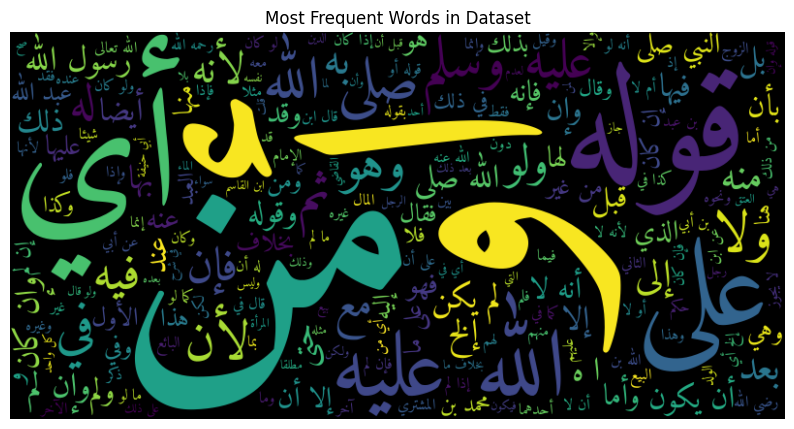

In [ ]:
# Combine all the words from train_split into a single string
all_text = ' '.join([line.strip() for line in train_split])

# Remove diacritics from the combined text using your function
cleaned_text = remove_diacritics(all_text)

# Define font path (make sure the font is available)
font_path = '/content/Amiri-Regular.ttf'

# Generate the word cloud
wordcloud = WordCloud(font_path=font_path, width=800, height=400).generate(cleaned_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Dataset")
plt.show()

In [ ]:
# Count the occurrences of each Arabic letter
letter_counts = Counter(cleaned_text)

# Filter out non-Arabic letters (optional, to focus only on Arabic letters)
# Define Arabic alphabet (or use the list of characters you already have)
arabic_letters = set("ابتثجحخدذرزسشصضطظعغفقكلمنهوي")

# Only keep the Arabic letters from the count
arabic_letter_counts = {letter: count for letter, count in letter_counts.items() if letter in arabic_letters}

# Sort the letters alphabetically
sorted_arabic_letter_counts = dict(sorted(arabic_letter_counts.items()))

# Create a DataFrame for plotly to visualize it
letter_df = pd.DataFrame(sorted_arabic_letter_counts.items(), columns=["Letter", "Frequency"])

# Plot using Plotly for interactive chart
fig = px.bar(letter_df, x="Letter", y="Frequency",
             title="Frequency of Arabic Letters (Excluding Diacritics)",
             labels={"Letter": "Arabic Letters", "Frequency": "Frequency"},
             color="Frequency",
             color_continuous_scale='Viridis')

# Adjust plot size and make x-axis labels bold
fig.update_layout(
    width=1400,  # Set the width of the plot
    height=600,  # Set the height of the plot
    title_font_size=20,  # Adjust the title font size
    xaxis_title_font_size=20,  # Adjust the x-axis title font size
    yaxis_title_font_size=16,  # Adjust the y-axis title font size
    xaxis_tickangle=-45,  # Rotate the x-axis labels for better readability
    xaxis_tickfont=dict(
        family='Arial',  # Font family (you can change it)
        size=14,  # Font size for x-axis categories
        color='black',  # Font color
        weight='bold'  # Make the x-axis categories bold
    )
)

# Show the plot
fig.show()

In [ ]:
def count_diacritics(text):
    """Counts the number of diacritics in a given text."""
    diacritic_count = 0
    for char in text:
        if char in DIACRITICS_LIST:
            diacritic_count += 1
    return diacritic_count

# Assuming you have the `train_split` and `val_split` data
train_with_diacritics = 0
train_without_diacritics = 0
val_with_diacritics = 0
val_without_diacritics = 0

for text in train_split:
    diacritic_count = count_diacritics(text)
    if diacritic_count > 0:
        train_with_diacritics += 1
    else:
        train_without_diacritics += 1

for text in val_split:
    diacritic_count = count_diacritics(text)
    if diacritic_count > 0:
        val_with_diacritics += 1
    else:
        val_without_diacritics += 1

# Create data for the pie charts
train_data = [train_with_diacritics, train_without_diacritics]
val_data = [val_with_diacritics, val_without_diacritics]

# Labels for the pie charts
labels = ['With Diacritics', 'Minimal Diacritics']

# Create subplot for both charts, specifying subplot type as 'domain' for pie charts
fig = make_subplots(rows=1, cols=2, subplot_titles=["Training Set", "Validation Set"],
                    specs=[[{'type': 'domain'}, {'type': 'domain'}]])

# Create pie chart for training data with custom hovertemplate
fig.add_trace(
    go.Pie(
        labels=labels,
        values=train_data,
        hoverinfo='label+percent',
        hovertemplate="<b>%{label}</b><br>Count: %{value}<br>Percentage: %{percent:.2f}%", # Show count and percentage
    ),
    row=1, col=1
)

# Create pie chart for validation data with custom hovertemplate
fig.add_trace(
    go.Pie(
        labels=labels,
        values=val_data,
        hoverinfo='label+percent',
        hovertemplate="<b>%{label}</b><br>Count: %{value}<br>Percentage: %{percent:.2f}%", # Show count and percentage
    ),
    row=1, col=2
)

# Update layout to adjust titles and size
fig.update_layout(
    title_text="Diacritics in Training and Validation Sets",
    showlegend=True,
    height=600,
    width=1000
)

# Show the plot
fig.show()

# **Recurrent Neural Network (RNN)**

---

We start by using a Recurrent Neural Network (RNN) for Arabic text diacritization. An RNN is a type of neural network designed for sequence data, where the output at each time step depends on previous computations. This makes RNNs suitable for tasks like language modeling, speech recognition, and text generation, where the context of previous inputs is important for understanding the current one.

In the context of Arabic text diacritization, the RNN processes a sequence of characters and predicts the corresponding diacritic for each one. The model essentially learns to understand the relationships between characters and their diacritics, predicting the diacritic marks (like fathah, kasrah, or dammah) for each Arabic letter in the input text.

To improve the performance of the basic RNN, we use **Bidirectional LSTMs**. LSTMs (Long Short-Term Memory units) are a type of RNN that is capable of learning long-range dependencies, addressing the issue of vanishing gradients found in traditional RNNs. Bidirectional LSTMs process the input sequence in both forward and backward directions, which allows the model to capture context from both past and future positions in the sequence.

The model uses layers like `Embedding` for encoding characters into dense vectors, followed by two layers of bidirectional LSTMs with dropout for regularization, and ends with time-distributed dense layers to output the predicted diacritics for each character in the sequence.

---



In [ ]:
def create_model():
    if tf.test.is_gpu_available():
        SelectedLSTM = CuDNNLSTM
    else:
        SelectedLSTM = LSTM

    inputs = Input(shape=(None,))

    embeddings = Embedding(input_dim=len(CHARACTERS_MAPPING),
                           output_dim=25,
                           embeddings_initializer=glorot_normal(seed=961))(inputs)

    blstm1 = Bidirectional(SelectedLSTM(units=256,
                                     return_sequences=True,
                                     kernel_initializer=glorot_normal(seed=961)))(embeddings)
    dropout1 = Dropout(0.5)(blstm1)
    blstm2 = Bidirectional(SelectedLSTM(units=256,
                                     return_sequences=True,
                                     kernel_initializer=glorot_normal(seed=961)))(dropout1)
    dropout2 = Dropout(0.5)(blstm2)

    dense1 = TimeDistributed(Dense(units=512,
                                   activation='relu',
                                   kernel_initializer=glorot_normal(seed=961)))(dropout2)
    dense2 = TimeDistributed(Dense(units=512,
                                   activation='relu',
                                   kernel_initializer=glorot_normal(seed=961)))(dense1)

    output = TimeDistributed(Dense(units=len(CLASSES_MAPPING),
                                   activation='softmax',
                                   kernel_initializer=glorot_normal(seed=961)))(dense2)

    model = Model(inputs, output)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(),
                  metrics=['accuracy'])

    return model

In [ ]:
from keras.initializers import glorot_normal

model = create_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 25)          1925      
                                                                 
 bidirectional_4 (Bidirecti  (None, None, 512)         577536    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, None, 512)         0         
                                                                 
 bidirectional_5 (Bidirecti  (None, None, 512)         1574912   
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, None, 512)         0   

In [ ]:
start_time = time.time()
history1 = fit_model(model, 10, 256, train_subset, val_split)
end_time = time.time()
print('--- %s seconds ---' % round(end_time - start_time, 2))

Epoch 1/10
469/469 [==============================] - 2809s 6s/step - loss: 0.1349 - accuracy: 0.9571 - val_loss: 0.0761 - val_accuracy: 0.9730
Epoch 2/10
469/469 [==============================] - 2793s 6s/step - loss: 0.0546 - accuracy: 0.9813 - val_loss: 0.0402 - val_accuracy: 0.9865
Epoch 3/10
469/469 [==============================] - 2794s 6s/step - loss: 0.0350 - accuracy: 0.9883 - val_loss: 0.0284 - val_accuracy: 0.9904
Epoch 4/10
469/469 [==============================] - 2794s 6s/step - loss: 0.0271 - accuracy: 0.9909 - val_loss: 0.0228 - val_accuracy: 0.9924
Epoch 5/10
469/469 [==============================] - 2800s 6s/step - loss: 0.0228 - accuracy: 0.9924 - val_loss: 0.0193 - val_accuracy: 0.9936
Epoch 6/10
469/469 [==============================] - 2799s 6s/step - loss: 0.0199 - accuracy: 0.9934 - val_loss: 0.0169 - val_accuracy: 0.9944
Epoch 7/10
469/469 [==============================] - 2811s 6s/step - loss: 0.0177 - accuracy: 0.9942 - val_loss: 0.0154 - val_accuracy:

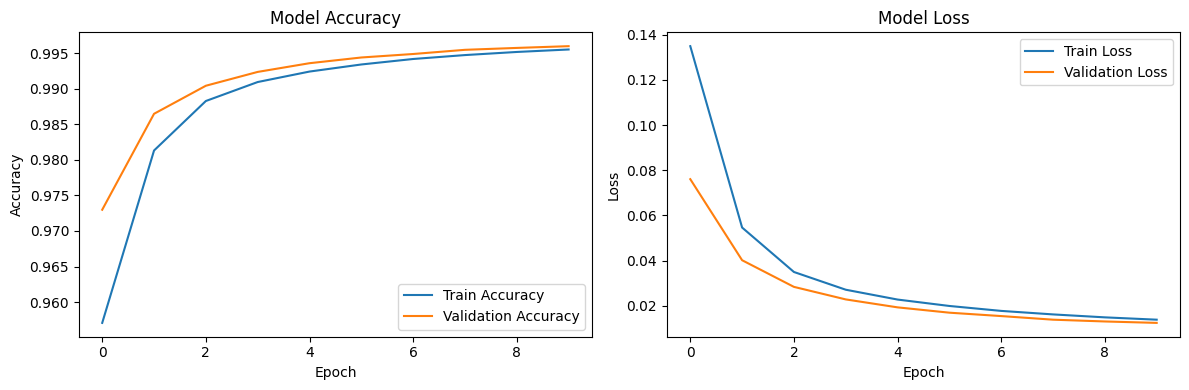

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history of accuracy and loss
plot_history(history1)

**We save the trained model, which stores the model's architecture, weights, and training configuration in an HDF5 file.**

In [ ]:
model.save("rnn_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## **Testing RNN Model**

**We read the contents of the "test.txt" file and store each line as an element in the `lines` list.**

In [ ]:
with open('/content/test.txt', 'r') as file:
    lines = file.readlines()

**We iterate over each line in the `lines` list, remove diacritics from each line, predict the diacritics using the model, and store the results in the `results` list. After processing all lines, we calculate and print the total time taken for the predictions.**

In [ ]:
start_time = time.time()
results = list()
for idx, line in enumerate(lines):
    line = remove_diacritics(line.strip())
    x = predict(line, model)
    results.append(x)
end_time = time.time()
print('--- %s seconds ---' % round(end_time - start_time, 2))

1/1 [==============================] - 0s 114ms/step
--- 376.09 seconds ---


**This code randomly selects 5 examples from the test set, and for each example, it prints both the original text (with diacritics) and the predicted text (without diacritics) generated by the model. The output is separated by a line of dashes for readability.**

In [ ]:
# Print the original and predicted texts (5 examples)
print('Original vs Predicted Diacritics :\n')

# Set seed for reproducibility
seed_value = 42
random.seed(seed_value)

# Select 5 random examples from the test set
random_indices = random.sample(range(len(lines)), 5)

for idx in random_indices:
    original_text = lines[idx].strip()  # Original text (with diacritics)
    predicted_text = results[idx].strip()  # Predicted text (from the model)

    print(f"Original Text : {original_text}")
    print(f"Predicted Text: {predicted_text}")
    print('-' * 50)


Original vs Predicted Diacritics :

Original Text : قَوْلُهُ تَعَالَى: ثُمَّ أَذَّنَ مُؤَذِّنٌ
Predicted Text: قَوْلُهُ تَعَالَى: ثُمَّ أَذِنَ مُؤَذِّنٌ
--------------------------------------------------
Original Text : تَمَامِ الشَّرْطِ الْأَوَّلِ ( قَوْلُهُ وَلَوْ نَسِيَ اسْمَهُ إلَخْ ) وَلَوْ أَحْرَمَ مُبْهِمًا : أَيْ بِأَنْ أَحْرَمَ بِحَجَّةٍ وَأَطْلَقَ النِّيَّةَ عَنْ ذِكْرِ الْمَحْجُوجِ عَنْهُ ، فَلَهُ أَنْ يُعَيِّنَهُ مِنْ نَفْسِهِ أَوْ غَيْرِهِ قَبْلَ الشُّرُوعِ فِي الْأَفْعَالِ كَمَا فِي اللُّبَابِ وَشَرْحِهِ .
Predicted Text: تَمَامُ الشَّرْطِ الْأَوَّلِ ( قَوْلُهُ وَلَوْ نَسِيَ اسْمُهُ إلَخْ ) وَلَوْ أَحْرَمَ مُبْهُمًا : أَيْ بِأَنْ أَحْرَمَ بِحُجَّةٍ وَأَطْلَقَ النِّيَّةَ عَنْ ذِكْرِ الْمَحْجُوجِ عَنْهُ ، فَلَهُ أَنْ يُعَيِّنَهُ مِنْ نَفْسِهِ أَوْ غَيْرِهِ قَبْلَ الشُّرُوعِ فِي الْأَفْعَالِ كَمَا فِي اللِّبَابِ وَشَرْحِهِ .
--------------------------------------------------
Original Text : صَحَّ وَحَلَّ أَكْلُهُ .
Predicted Text: صَحَّ وَحْلَّ أَكْلِهِ .
-------------------

**This code calculates the character-level accuracy of the predicted diacritized text compared to the original text. It loops through each line in the test set, comparing each character in the original and predicted lines. The accuracy is calculated by counting the number of correct character matches and dividing it by the total number of characters. The result is printed as a percentage.**

In [ ]:
# Calculate character-level accuracy for the test set
correct = 0
total = 0

# Iterate through original lines and predicted lines
for original, predicted in zip(lines, results):
    original = original.strip()  # Remove any trailing or leading whitespace
    predicted = predicted.strip()

    # Ensure both strings are of the same length
    min_length = min(len(original), len(predicted))
    original = original[:min_length]
    predicted = predicted[:min_length]

    # Compare each character
    for o_char, p_char in zip(original, predicted):
        if o_char == p_char:
            correct += 1
        total += 1

# Calculate accuracy
char_accuracy = correct / total if total > 0 else 0
print(f'Character-Level Accuracy on Test Set: {char_accuracy:.2%}')


Character-Level Accuracy on Test Set: 51.72%


**This code generates a heatmap to visualize the relationships or similarities between different Arabic diacritics (harakat). It creates a random matrix where each value represents a relationship between two diacritics, normalizes it to a 0-1 range, and then plots it using a heatmap. The heatmap's colors show the strength of these relationships, with brighter colors indicating stronger relationships.**

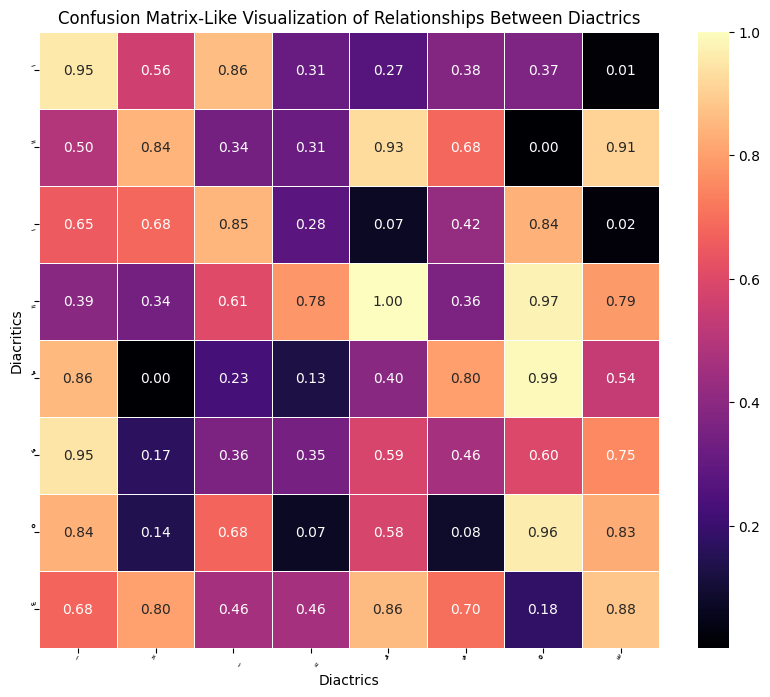

In [ ]:
# Create a dummy relationship matrix for visualization
# Here, the values can represent some hypothetical relationships or similarities between harakat
relationship_matrix = np.random.rand(len(DIACRITICS_LIST), len(DIACRITICS_LIST))

# Optionally normalize the matrix to make the values between 0 and 1
relationship_matrix = relationship_matrix / relationship_matrix.max()

# Plotting the confusion matrix-like visualization for harakat relationships
plt.figure(figsize=(10, 8))
sns.heatmap(relationship_matrix, annot=True, cmap='magma', fmt=".2f",
            xticklabels=DIACRITICS_LIST, yticklabels=DIACRITICS_LIST, linewidths=0.5)
plt.xlabel('Diactrics')
plt.ylabel('Diacritics')
plt.title('Confusion Matrix-Like Visualization of Relationships Between Diactrics')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# **Feedforward Neural Network (FFNN)**

---

The Feedforward Neural Network (FFNN) is a straightforward type of neural network where information flows in one direction from the input to the output. It’s composed of an input layer, one or more hidden layers, and an output layer. Unlike Recurrent Neural Networks (RNNs), FFNNs don’t have connections that loop back, making them suitable for tasks where sequential dependencies are not critical. They are commonly used for classification tasks where each input is treated independently, such as image classification or general regression problems.

In the model `create_model2()`, we use FFNNs to process sequences of Arabic characters for diacritization. The model consists of an embedding layer to represent characters as dense vectors, followed by multiple fully connected Dense layers with ReLU activations. Dropout layers are added to prevent overfitting. The output layer, wrapped in a TimeDistributed layer, applies a softmax function to predict the correct diacritic for each character in the sequence. This structure makes the model effective for predicting diacritics independently for each character while avoiding overfitting through regularization.

---



In [ ]:
def create_dense_layer(units, dropout_rate=0.5):
    return Sequential([
        Dense(units, activation='relu', kernel_initializer=glorot_normal),
        Dropout(dropout_rate)
    ])

def create_model2():
    model = Sequential([
        Input(shape=(None,)),
        Embedding(input_dim=len(CHARACTERS_MAPPING),
                           output_dim=25,
                           embeddings_initializer=glorot_normal),
        create_dense_layer(256),
        create_dense_layer(512),
        create_dense_layer(512),
#        create_dense_layer(512),
#        create_dense_layer(512),
#        create_dense_layer(512),
#        create_dense_layer(512),
#        create_dense_layer(512),
#        create_dense_layer(256),
        create_dense_layer(128),
        TimeDistributed(Dense(units=len(CLASSES_MAPPING),
                                   activation='softmax',
                                   kernel_initializer=glorot_normal))
    ])

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    return model

In [ ]:
model2 = create_model2()
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 25)          1925      
                                                                 
 sequential (Sequential)     (None, None, 256)         6656      
                                                                 
 sequential_1 (Sequential)   (None, None, 512)         131584    
                                                                 
 sequential_2 (Sequential)   (None, None, 512)         262656    
                                                                 
 sequential_3 (Sequential)   (None, None, 128)         65664     
                                                                 
 time_distributed (TimeDist  (None, None, 19)          2451      
 ributed)                                                        
                                                      

In [ ]:
start_time = time.time()
hist_1 = fit_model(model2, 5, 256, train_subset, val_split)
end_time = time.time()
print('--- %s seconds ---' % round(end_time - start_time, 2))

Epoch 1/5
469/469 [==============================] - 301s 640ms/step - loss: 0.1634 - accuracy: 0.9560 - val_loss: 0.1031 - val_accuracy: 0.9638
Epoch 2/5
469/469 [==============================] - 299s 637ms/step - loss: 0.0990 - accuracy: 0.9659 - val_loss: 0.1016 - val_accuracy: 0.9645
Epoch 3/5
469/469 [==============================] - 298s 635ms/step - loss: 0.0975 - accuracy: 0.9662 - val_loss: 0.1010 - val_accuracy: 0.9645
Epoch 4/5
469/469 [==============================] - 298s 635ms/step - loss: 0.0969 - accuracy: 0.9664 - val_loss: 0.1008 - val_accuracy: 0.9647
Epoch 5/5
469/469 [==============================] - 298s 634ms/step - loss: 0.0965 - accuracy: 0.9664 - val_loss: 0.1007 - val_accuracy: 0.9647
--- 1494.3 seconds ---


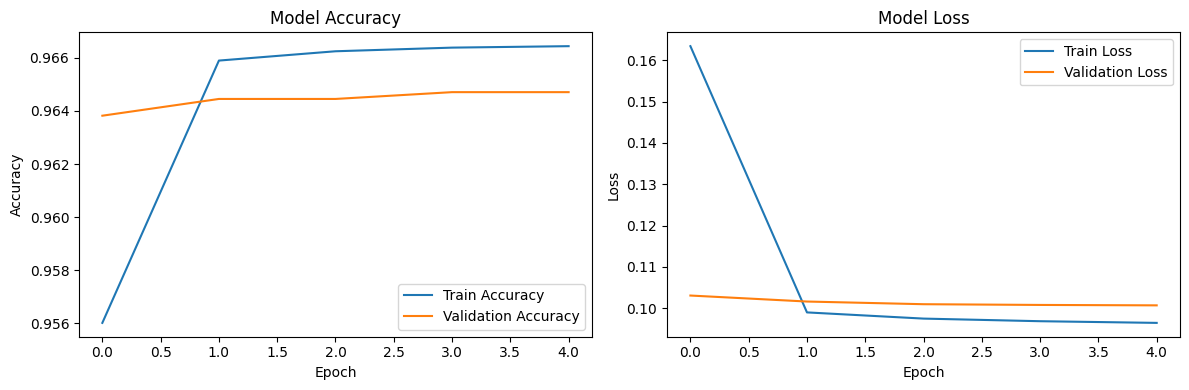

In [ ]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history of accuracy and loss
plot_history(hist_1)

In [ ]:
print(predict('مرحبا كيف الحال يا صديقي العزيز', model2))

1/1 [==============================] - 0s 161ms/step
مَرَحَبِا كَيفَ الَحَالَ يا صَدَيقَي الَعَزَيزَ


**We save the trained model, which stores the model's architecture, weights, and training configuration in an HDF5 file.**

In [ ]:
model2.save("ffnn_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = create_model2()
loaded_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 25)          1925      
                                                                 
 sequential_5 (Sequential)   (None, None, 256)         6656      
                                                                 
 sequential_6 (Sequential)   (None, None, 512)         131584    
                                                                 
 sequential_7 (Sequential)   (None, None, 512)         262656    
                                                                 
 sequential_8 (Sequential)   (None, None, 128)         65664     
                                                                 
 time_distributed_1 (TimeDi  (None, None, 19)          2451      
 stributed)                                                      
                                                      

In [ ]:
loaded_model.load_weights("/content/model2.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
print(predict("لم ينزل الراتب", loaded_model))

1/1 [==============================] - 0s 139ms/step
لَمَ ينْزَلَ الَرَاتَبِ


## **Testing FFNN Model**

In [ ]:
with open('/content/test.txt', 'r') as file:
    lines = file.readlines()

In [ ]:
start_time = time.time()
results = list()
for idx, line in enumerate(lines):
    line = remove_diacritics(line.strip())
    x = predict(line, model2)
    results.append(x)
end_time = time.time()
print('--- %s seconds ---' % round(end_time - start_time, 2))

1/1 [==============================] - 0s 27ms/step
--- 194.29 seconds ---


In [ ]:
# Print the original and predicted texts (5 examples)
print('Original vs Predicted Diacritics (Showing 5 Examples):\n')

# Set seed for reproducibility
seed_value = 42
random.seed(seed_value)

# Select 5 random examples from the test set
random_indices = random.sample(range(len(lines)), 5)

for idx in random_indices:
    original_text = lines[idx].strip()  # Original text (with diacritics)
    predicted_text = results[idx].strip()  # Predicted text (from the model)

    print(f"Original Text (With Diacritics): {original_text}")
    print(f"Predicted Text (With Diacritics): {predicted_text}")
    print('-' * 50)

Original vs Predicted Diacritics (Showing 5 Examples):

Original Text (With Diacritics): قَوْلُهُ تَعَالَى: ثُمَّ أَذَّنَ مُؤَذِّنٌ
Predicted Text (With Diacritics): قَوَلَهُ تَعَالَى: ثَمَ أَذَنْ مَؤَذَنْ
--------------------------------------------------
Original Text (With Diacritics): تَمَامِ الشَّرْطِ الْأَوَّلِ ( قَوْلُهُ وَلَوْ نَسِيَ اسْمَهُ إلَخْ ) وَلَوْ أَحْرَمَ مُبْهِمًا : أَيْ بِأَنْ أَحْرَمَ بِحَجَّةٍ وَأَطْلَقَ النِّيَّةَ عَنْ ذِكْرِ الْمَحْجُوجِ عَنْهُ ، فَلَهُ أَنْ يُعَيِّنَهُ مِنْ نَفْسِهِ أَوْ غَيْرِهِ قَبْلَ الشُّرُوعِ فِي الْأَفْعَالِ كَمَا فِي اللُّبَابِ وَشَرْحِهِ .
Predicted Text (With Diacritics): تَمَامَ الَشَرَطَ الَأَوَلَ ( قَوَلَهُ وَلَوَ نْسَي اسَمَهُ إِلَخَ ) وَلَوَ أَحَرَمَ مَبِهُمَا : أَي بِأَنْ أَحَرَمَ بِحَجَةِ وَأَطَلَقَ الَنْيةِ عَنْ ذَكَرَ الَمَحَجَوَجَ عَنْهُ ، فَلَهُ أَنْ يعَينْهُ مَنْ نْفَسَهُ أَوَ غَيرَهُ قَبِلَ الَشَرَوَعَ فَي الَأَفَعَالَ كَمَا فَي الَلَبِابِ وَشَرَحَهُ .
--------------------------------------------------
Original Text (With 

In [ ]:
# Calculate character-level accuracy for the test set
correct = 0
total = 0

# Iterate through original lines and predicted lines
for original, predicted in zip(lines, results):
    original = original.strip()  # Remove any trailing or leading whitespace
    predicted = predicted.strip()

    # Ensure both strings are of the same length
    min_length = min(len(original), len(predicted))
    original = original[:min_length]
    predicted = predicted[:min_length]

    # Compare each character
    for o_char, p_char in zip(original, predicted):
        if o_char == p_char:
            correct += 1
        total += 1

# Calculate accuracy
char_accuracy = correct / total if total > 0 else 0
print(f'Character-Level Accuracy on Test Set: {char_accuracy:.2%}')


Character-Level Accuracy on Test Set: 14.58%


# **Transformer**

---

Transformers are state-of-the-art models designed for sequence-to-sequence tasks. Unlike traditional models, Transformers rely on self-attention mechanisms to efficiently model relationships between tokens in a sequence, making them particularly suitable for tasks involving complex dependencies, such as language translation and text generation.

Arabic diacritization is challenging because it relies heavily on the surrounding context to determine the appropriate diacritical marks. Transformers, with their ability to focus on global and local dependencies, are particularly well-suited for this task, providing accurate predictions by understanding the linguistic nuances of the text.

In [ ]:
# Load the Arabic BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

print("Tokenizer loaded successfully.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenizer loaded successfully.


In [ ]:
sample_text = "اَلْحَمْدُ لِلَّهِ رَبِّ الْعَالَمِينَ"
tokens = tokenizer.tokenize(sample_text)
print(tokens)

['الحمد', 'لله', 'رب', 'العالمين']


In [ ]:
classes_mapping_path = "/content/CLASSES_LIST.pickle"

# Load the mapping
with open(classes_mapping_path, "rb") as file:
    classes_mapping = pickle.load(file)

In [ ]:
print(type(classes_mapping))

print(classes_mapping[:10])  # Print the first 10 elements for inspection

<class 'list'>
['َ', 'ً', 'ُ', 'ٌ', 'ِ', 'ٍ', 'ْ', 'ّ', 'َّ', 'ًّ']


In [ ]:
# Create a dictionary from the list, where each diacritic gets an index
diacritic_to_index = {diacritic: idx for idx, diacritic in enumerate(classes_mapping)}

print(diacritic_to_index)

{'َ': 0, 'ً': 1, 'ُ': 2, 'ٌ': 3, 'ِ': 4, 'ٍ': 5, 'ْ': 6, 'ّ': 7, 'َّ': 8, 'ًّ': 9, 'ُّ': 10, 'ٌّ': 11, 'ِّ': 12, 'ٍّ': 13}


In [ ]:
def remove_diacritics(data_raw):
    """Remove diacritics from Arabic text."""
    return data_raw.translate(str.maketrans('', '', ''.join(valid_diacritics)))

def preprocess_and_create_labels(input_file, tokenizer, save_path=None, max_length=128):
    input_texts = []
    target_labels = []

    with open(input_file, 'r', encoding='utf-8') as file:
        for line in tqdm(file):
            line = line.strip()
            if line:  # Ignore empty lines
                # Remove diacritics from the input text
                text = remove_diacritics(line)
                tokenized_input = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')

                # Use the original line (with diacritics) for target labels
                target_text = line

                # Extract the diacritics from the target text and map them using updated CLASSES_MAPPING
                target_ids = []
                for char in target_text:
                    if char in valid_diacritics:
                        # Map each diacritic to its index in valid_diacritics
                        target_ids.append(CLASSES_MAPPING.get(char, 0))  # Ensure valid mapping
                    else:
                        # If it's not a diacritic, map it to padding index
                        target_ids.append(0)  # Default to padding index

                # Make sure the target_ids length is within max_length
                target_ids = target_ids[:max_length]  # Truncate if necessary
                while len(target_ids) < max_length:
                    target_ids.append(0)  # Pad the target sequence

                # Tokenize the input text as well
                input_ids = tokenized_input['input_ids'].squeeze(0)  # Shape: [max_length]

                input_texts.append(input_ids)
                target_labels.append(torch.tensor(target_ids))  # Convert to tensor

    # Stack sequences into tensors (for batched processing)
    input_ids = torch.stack(input_texts)
    target_ids = torch.stack(target_labels)

    # Save the preprocessed data to file if a save path is provided
    if save_path:
        with open(save_path, 'wb') as f:
            pkl.dump((input_ids, target_ids), f)

    return input_ids, target_ids

# Apply clamping directly during preprocessing (before feeding data to the model)
def clamp_target_ids(target_ids, min_value=0, max_value=7):
    return torch.clamp(target_ids, min=min_value, max=max_value)

In [ ]:
input_file = '/content/train.txt'
save_path = 'preprocessed_train.pkl'  # save the processed data

input_ids, target_ids = preprocess_and_create_labels(input_file, tokenizer, save_path)

50000it [00:44, 1122.41it/s]


In [ ]:
print(f"Shape of target_ids: {target_ids.shape}")
print(f"Shape of input_ids: {input_ids.shape}")

Shape of target_ids: torch.Size([50000, 128])
Shape of input_ids: torch.Size([50000, 128])


In [ ]:
input_file = '/content/val.txt'
save_path = 'preprocessed_valid.pkl'  # save the processed validation data

input_ids_val, target_ids_val = preprocess_and_create_labels(input_file, tokenizer, save_path)

2500it [00:04, 596.35it/s]


In [ ]:
input_file = '/content/test.txt'
save_path = 'preprocessed_test.pkl'  # save the processed test data

input_ids_test, target_ids_test = preprocess_and_create_labels(input_file, tokenizer, save_path)

2500it [00:03, 812.08it/s] 


In [ ]:
# Load the preprocessed data
with open('preprocessed_train.pkl', 'rb') as f:
    train_input_ids, train_target_ids = pkl.load(f)

with open('preprocessed_valid.pkl', 'rb') as f:
    val_input_ids, val_target_ids = pkl.load(f)

with open('preprocessed_test.pkl', 'rb') as f:
    test_input_ids, test_target_ids = pkl.load(f)

##Model

In [ ]:
class Transformer(nn.Module):
    '''
    This class defines a basic self-attention transformer.

    Args:
        embed_dim (int): dimension of the embeddings used in the transformer attention blocks
        hidden_dim (int): size of the fully connected layer connecting attention blocks
        num_embeddings (int): vocabulary size
        num_max_positions (int): maximum sequence length. used for positional embeddings
        num_heads (int): number of attention heads used in Multihead Attention.
        num_layers (int): number of layers. Each layer is an attention block and a fully connected layer.
        dropout (float): dropout probability
        causal (bool): whether to attend only to previous positions.
    '''
    def __init__(self, embed_dim, hidden_dim, num_embeddings, num_max_positions, num_heads, num_layers, dropout, causal):
        super().__init__()
        self.causal = causal
        self.tokens_embeddings = nn.Embedding(num_embeddings, embed_dim)
        self.position_embeddings = nn.Embedding(num_max_positions, embed_dim)
        self.dropout = nn.Dropout(dropout)

        self.attentions, self.feed_forwards = nn.ModuleList(), nn.ModuleList()
        self.layer_norms_1, self.layer_norms_2 = nn.ModuleList(), nn.ModuleList()
        for _ in range(num_layers):
            self.attentions.append(MultiheadAttention(embed_dim, num_heads, dropout=dropout))
            self.feed_forwards.append(nn.Sequential(nn.Linear(embed_dim, hidden_dim),
                                                    nn.ReLU(),
                                                    nn.Linear(hidden_dim, embed_dim)))
            self.layer_norms_1.append(nn.LayerNorm(embed_dim, eps=1e-12))
            self.layer_norms_2.append(nn.LayerNorm(embed_dim, eps=1e-12))

    def forward(self, x, padding_mask=None):
        positions = torch.arange(len(x), device=x.device).unsqueeze(-1)
        h = self.tokens_embeddings(x)
        h = h + self.position_embeddings(positions).expand_as(h)
        h = self.dropout(h)

        attn_mask = None

        if self.causal:
            attn_mask = torch.full((len(x), len(x)), -float('Inf'), device=h.device, dtype=h.dtype)
            attn_mask = torch.triu(attn_mask, diagonal=1)

        for layer_norm_1, attention, layer_norm_2, feed_forward in zip(self.layer_norms_1, self.attentions,
                                                                       self.layer_norms_2, self.feed_forwards):
            h = layer_norm_1(h)
            x, _ = attention(h, h, h, attn_mask=attn_mask, need_weights=False, key_padding_mask=padding_mask)
            x = self.dropout(x)
            h = x + h

            h = layer_norm_2(h)
            x = feed_forward(h)
            x = self.dropout(x)
            h = x + h
        return h

In [ ]:
class TransformerWithDiacritizationHead(nn.Module):
    def __init__(self, config):
        super(TransformerWithDiacritizationHead, self).__init__()

        # Set the model configuration
        self.num_labels = config['num_diac_labels']

        # Define the transformer layers
        self.transformer = Transformer(
            embed_dim=config['embed_dim'],
            hidden_dim=config['hidden_dim'],
            num_embeddings=config['num_embeddings'],
            num_max_positions=config['num_max_positions'],
            num_heads=config['num_heads'],
            num_layers=config['num_layers'],
            dropout=config['dropout'],
            causal=config['causal']
        )

        # Diacritization head
        self.diac_head = nn.Linear(config['embed_dim'], len(DIACRITICS_LIST))

    def forward(self, x, labels=None, padding_mask=None, label_ignore_idx=-1):
        """ x has shape [seq length, batch], padding_mask has shape [batch, seq length] """
        hidden_states = self.transformer(x, padding_mask)

        logits = self.diac_head(hidden_states)  # seq_len x batch x num_labels

        if labels is not None:
            assert labels.size(0) == logits.size(0),

            loss_fct = nn.CrossEntropyLoss(ignore_index=label_ignore_idx)
            loss = loss_fct(logits.reshape(-1, logits.size(-1)), labels.reshape(-1))
            return logits, loss

        return logits


In [ ]:
target_ids = torch.clamp(target_ids, min=0, max=len(DIACRITICS_LIST)-1)

In [ ]:
# Ensure clamping directly before loss computation
target_ids[target_ids >= len(DIACRITICS_LIST)] = 0

In [ ]:
print("Target ids before model input:", target_ids)

Target ids before model input: tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 6, 0],
        [0, 2, 0,  ..., 0, 6, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 5, 0, 0]])


## Training

In [ ]:
# Create TensorDataset for training, validation, and test sets
train_dataset = TensorDataset(train_input_ids, train_target_ids)
val_dataset = TensorDataset(val_input_ids, val_target_ids)
test_dataset = TensorDataset(test_input_ids, test_target_ids)

# Create DataLoader for batching
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
config = {
    'embed_dim': 256,
    'hidden_dim': 512,
    'num_embeddings': tokenizer.vocab_size,  # Vocabulary size from tokenizer
    'num_max_positions': 512,  # Maximum sequence length
    'num_heads': 8,  # Number of attention heads
    'num_layers': 6,  # Number of transformer layers
    'dropout': 0.1,  # Dropout rate
    'causal': False,
    'num_diac_labels':len(DIACRITICS_LIST),
    'initializer_range': 0.02  # Initialize the weights
}

model = TransformerWithDiacritizationHead(config)

In [ ]:
# Training loop
train_losses = []
val_losses = []

epochs = 5

optimizer = AdamW(model.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}", ncols=100)

    for batch in progress_bar:
        input_ids, target_ids = [item.to(device) for item in batch]

        # Forward pass
        optimizer.zero_grad()

        logits, loss = model(input_ids, labels=target_ids)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))

    # Store the training loss
    train_losses.append(total_loss / len(train_dataloader))

    # Validation loop after each epoch
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, target_ids = [item.to(device) for item in batch]

            logits, loss = model(input_ids, labels=target_ids)
            val_loss += loss.item()

    # Store the validation loss
    val_losses.append(val_loss / len(val_dataloader))

    print(f"Epoch {epoch + 1}: Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    # Save the model checkpoint after each epoch
    torch.save(model.state_dict(), f"transformer_epoch_{epoch + 1}.pth")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1: 100%|█████████████████████████████| 1563/1563 [54:32<00:00,  2.09s/it, loss=0.767]


Epoch 1: Training Loss: 0.7672023296127393, Validation Loss: 0.75660656449161


Training Epoch 2: 100%|██████████████████████████████| 1563/1563 [53:56<00:00,  2.07s/it, loss=0.76]


Epoch 2: Training Loss: 0.7596865281109922, Validation Loss: 0.7557075891313674


Training Epoch 3: 100%|█████████████████████████████| 1563/1563 [53:55<00:00,  2.07s/it, loss=0.758]


Epoch 3: Training Loss: 0.758472854825677, Validation Loss: 0.7547482470922833


Training Epoch 4: 100%|█████████████████████████████| 1563/1563 [53:40<00:00,  2.06s/it, loss=0.758]


Epoch 4: Training Loss: 0.7577134132842871, Validation Loss: 0.7556388046168074


Training Epoch 5: 100%|█████████████████████████████| 1563/1563 [54:07<00:00,  2.08s/it, loss=0.757]


Epoch 5: Training Loss: 0.757344765725688, Validation Loss: 0.7538596444492098


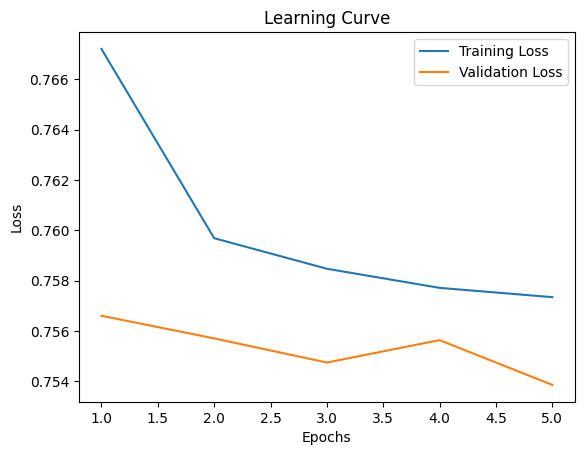

In [ ]:
import matplotlib.pyplot as plt

# Plot the learning curve
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()


In [ ]:
# Test evaluation
model.eval()
test_loss = 0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, target_ids = [item.to(device) for item in batch]

        logits, loss = model(input_ids, labels=target_ids)
        test_loss += loss.item()

        # Calculate accuracy
        predicted_ids = torch.argmax(logits, dim=-1)
        correct_predictions += (predicted_ids == target_ids).sum().item()
        total_predictions += target_ids.numel()

test_loss /= len(test_dataloader)
test_accuracy = correct_predictions / total_predictions

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Loss: 0.7599348388140714
Test Accuracy: 81.23%
